# PyTorch Implementation: Deep Painterly Harmonization
---
Seonkyu Park

# Introduction

## Contents

1. Introduction
1. Preparation
  - Model
  - Input Images
2. First Pass
  - Independent Mapping
  - Reconstruction
3. Second Pass
  - Consistent Mapping
  - Reconstruction
4. Post Processing
  - Chrominance Denoising
    

This article deals with an implementation of [Deep Painterly Harmonization](https://arxiv.org/abs/1804.03189) paper with PyTorch. Large part of codes refers to Sylvain Gugger's [blog post](https://sgugger.github.io/deep-painterly-harmonization.html) and [implementation](https://github.com/sgugger/Deep-Learning/blob/master/DeepPainterlyHarmonization.ipynb), but I tried to improve it as far as I can rather than just copy and paste it. Every code I wrote has been uploaded to my [github](https://github.com/SunQpark/DeepPainterlyHarmonization.git). The author's code can be found [here](https://github.com/luanfujun/deep-painterly-harmonization) and you can also get the example input images there. Since this notebook itself contains working codes, I highly recommend reading this article after cloning the repository, rather than reading the hard copy of it. List of modules needed are as following. Tested using pytorch 0.4.0 and torchvision 0.2.1, on nvidia GTX1080 GPU. I used formatted string(string that begins with f prefix) which are python 3.6 feature. If you wants to run this code with lower versions, they should be replaced with .format() or otherwise will give syntax error.

In [14]:
import sys, os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.models import vgg16_bn
from torchvision.utils import save_image
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Stage1

## Preparing CNN model

Define the CNN model which will be used as feature extracter. This class wraps vgg model imported in torchvision. Whenever called, this class will return intermediate feature maps as a python list. Note that in this algorithm, the vgg net is not for training but for extracting features of image. Run following cell, then pretrained model file(550 MB) will be downloaded to your local machine.

In [39]:
class FeatureExtracter(nn.Module):
    def __init__(self):
        super(FeatureExtracter, self).__init__()
        model = vgg16_bn(pretrained=True).features
        indices = [0, 3, 10, 17, 27, 37]
        self.layers = self._slice_layers(model, indices) 
    
    def forward(self, x):
        out = []
        for l in self.layers:
            x = l(x)
            out.append(x)
        return out
        
    def _slice_layers(self, model, indices):
        layers = []
        for i in range(len(indices) - 1):
            layer = nn.Sequential(*list(model.children())[indices[i]:indices[i + 1]])
            layers.append(layer)
        return nn.Sequential(*layers)

In [ ]:
model = FeatureExtracter()
model.eval()

Following line will set requires_grad flag of every parameters of model to false. Doing this will make model not trainable, but can save much of GPU memory which otherwise will be used for saving gradients of parameters.

In [ ]:
# freezing model parameters 
for p in model.parameters():
    p.requires_grad = False
print(model)

This model class will compute and return the wanted intermidiate feature maps of input image as a python list of tensors using pretrained VGG network.

## Preparing Inputs
The inputs of deep harmonization algorithm are following. Shape of all images are same except that the mask has 1 channel, while the others have 3(R, G, B) channels. 

**Style Image** is the background image that the object will be pasted.

**Content Image** is the image containing object that will be moved. 

**Mask** is a binary mask indicating the parts of image that contains moved object. The masks are set slightly larger than the object in stage1. 

**Target Image** is the tensor to be optimized. It is set to be a copy of input image in the first pass, and to be result of first pass in the second pass

Here are some samples of input images. Download example images from author's repository and copy or make symbolic link of data folder in the project root dir.

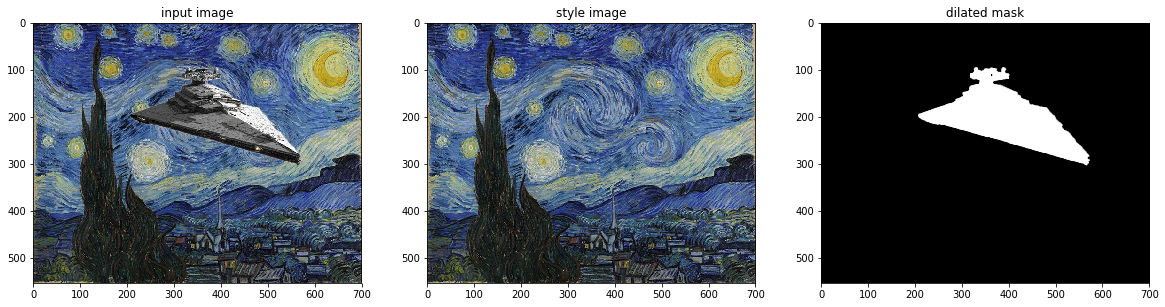

In [17]:
index = 9
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.title('input image')
plt.imshow(Image.open(os.path.join(f'data/{index}_naive.jpg')))
plt.subplot(132)
plt.title('style image')
plt.imshow(Image.open(os.path.join(f'data/{index}_target.jpg')))
plt.subplot(133)
plt.title('dilated mask')
plt.imshow(Image.open(os.path.join(f'data/{index}_c_mask.jpg')))

In [18]:
def prepare_input(data_dir, index, stage=1):
    # open images with PIL library
    img_style = Image.open(os.path.join(data_dir, f'{index}_target.jpg'))
    img_content = Image.open(os.path.join(data_dir, f'{index}_naive.jpg'))
    img_tight_mask = Image.open(os.path.join(data_dir, f'{index}_c_mask.jpg'))
    img_dil_mask = Image.open(os.path.join(data_dir, f'{index}_c_mask_dilated.jpg'))

    # Every pretrained models of pytorch expects input images transformed as follows ref: https://pytorch.org/docs/stable/torchvision/models.html
    to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std =[0.229, 0.224, 0.225])

    tsfm = transforms.Compose([to_tensor, normalize])

    # transform images and expand batch dimension
    tensor_style = tsfm(img_style).unsqueeze_(0)
    tensor_content = tsfm(img_content).unsqueeze_(0)
    tensor_batch = torch.cat([tensor_style, tensor_content.detach()], dim=0) # concat style and content images

    img_tight_mask = img_tight_mask.filter(ImageFilter.GaussianBlur(3))
    # tensor_tight_mask = to_tensor(img_tight_mask)[0].float().to(device)

    if stage == 2: #for stage 2
        img_inter = Image.open(os.path.join(data_dir, f'{index}_stage1_out.jpg'))
        tensor_inter = tsfm(img_inter).unsqueeze_(0)
        tensor_batch = torch.cat([tensor_batch, tensor_inter.detach()], dim=0)
    
    return tensor_batch, img_tight_mask, img_dil_mask

In [19]:
def resize_masks(mask, reference_output):
    result = []
    for l in reference_output:
        to_tensor = transforms.ToTensor()
        resize = transforms.Resize(l.shape[-2:])

        tensor_mask = to_tensor(resize(mask))[0] # apply transforms and drop color channels
        
        result.append(tensor_mask.byte().to(device))
    return result

Feed input batch to the model to gain the reference activations. I concatenated input images into one batch(4D tensor) for efficiently feeding them to model. indices of input in batch are, style image at index 0, and content image at index 1. Stage1 output image will be added to index 2 in stage2.
The content features will be used as is, but style features will go through some modifications(nearest neighbor matching). 
Before doing that, let's resize input mask(dilated one) to fit the intermediate feature maps.

In [20]:
image_index = 9
model = FeatureExtracter().to(device)
batch_inputs, img_tight_mask, img_dil_mask = prepare_input(data_dir='data/', index=image_index)
batch_inputs = batch_inputs.to(device)

features = model(batch_inputs) # python list of activations 
masks = resize_masks(img_dil_mask, features)

## vector representation of features

in this article, activation blocks are considered as a collection of vectors, rather than of channels. Following function selects activation vectors inside of given mask, and return flattened matrix whose columns are activation vector. If mask is None(Not given), this function just flatten the activation volume into a matrix with shape (channel, width \* height)


In [21]:
def select_mask(features, mask=None):
    """
    select activation vectors in mask
    features: (c, w, h)
    mask: (w, h)
    """
    assert(len(features.shape)==3)
    if mask is not None:
        activations = torch.masked_select(features, mask).view(features.shape[0], -1)
    else:
        activations = features.view(features.shape[0], -1)
    
    return activations

## Stage1: Independent Mapping

In the Independent mapping in stage1, we will find compute L2 distance between all the activation vectors of input and style images, and assign the L2-nearest index for the input activations inside the mask. 4th layer will be used as reference for this task.

In [22]:
def get_patches(features, mask=None):
    grid = [(-1, -1), (-1, 0), (-1, 1),
            ( 0, -1), ( 0, 0), ( 0, 1),
            ( 1, -1), ( 1, 0), ( 1, 1)]
    c, w, h = features.shape
    if mask is None:
        mask = torch.ones((w, h), dtype=torch.uint8)
    assert(mask.shape == (w, h))
    
    features = F.pad(features[None], (1, 1, 1, 1)).squeeze(0)
    mask = F.pad(mask, (2, 2, 2, 2))
    selected = []
    for offset in grid:
        dx, dy = offset
        x0, y0 = 1, 1
        x1, y1 = w+3, h+3
        
        offset_mask = mask[x0+dx : x1+dx , y0+dy : y1+dy].to(device)
        selected.append(select_mask(features, offset_mask))
    patches = torch.cat(selected)
    return patches

In [23]:
def nearest_search(f_input, f_style, mask):
    patch_input = get_patches(f_input, mask)
    patch_style = get_patches(f_style)
    
    # compute matrix of l2 norm between each pairs of patches
    l2_input = torch.sum(patch_input**2, dim=0).unsqueeze_(1)
    l2_style = torch.sum(patch_style**2, dim=0).unsqueeze_(0)
    
    l2_matrix = -2 * torch.mm(patch_input.t(), patch_style) + l2_input + l2_style # sqrt is omitted since it will have no effect on comparing
    return torch.argmin(l2_matrix, dim=1)

def independent_mapping(f_input, f_style, mask):
    nearest_idx = nearest_search(f_input, f_style, mask)
    # remap the activation vectors of style features using nearest indices
    mapped_features = torch.cat([row.take(nearest_idx).unsqueeze(0) for row in select_mask(f_style)], dim=0)
    mapped_style = f_style.masked_scatter_(mask, mapped_features)
    
    return mapped_style

In [ ]:
ref_features = []
ref_style = []
ref_content = []

print('Stage1: Begin Mapping')
with torch.no_grad():
    for i, (feat, mask) in enumerate(zip(features, masks)):
        feat_no_grad = feat
        f_style, f_content= torch.unbind(feat.detach(), dim=0)
        if i in [2, 3, 4]:
            f_style = independent_mapping(f_content, f_style, mask)
        ref_style.append(f_style)
        ref_content.append(f_content) 

## Stage1: Reconstruction

In this step, we will compute the loss functions for the optimization and optimize the pixels of input images using that losses.
loss functions used here are simmilar with the classical style transfer method by [Gatys et.al](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf). The only difference is that usage of mask, which prevents the unnecessary parts of features from being used to compute loss. However, if mask is not provided(None), these functions are identical to that of Gatys.

In [24]:
def gram(inp):
    mat = inp.view(inp.shape[0], -1)
    return torch.mm(mat, mat.t())

def loss_content(output, refer, mask=None, weight=10):
    return F.mse_loss(
        select_mask(output, mask),
        select_mask(refer, mask)) * weight

def gram_mse(output, refer, mask=None):
    if mask is not None:
        output = output * mask.float()
        refer = refer * mask.float()
    return F.mse_loss(
        gram(output),
        gram(refer))

def loss_style_stage1(fts_target, fts_style, masks, weight=10):
    s_loss = 0
    for i, (target, ref_s, mask) in enumerate(zip(fts_target, fts_style, masks)):
        s_loss += gram_mse(target.squeeze(0), ref_s, mask)
    return s_loss * weight / 3

Style loss function is computed from comparing 3nd, 4rd, 5th features of style reference layers and target featuremaps. The style loss is then averaged, multiplied by weight and added to the content loss, which is computed from 4th layer only.

In [25]:
def stage1_loss(fts_target, fts_style, fts_content, masks):
    s_loss = loss_style_stage1(fts_target[2:], ref_style[2:], masks[2:], weight=10)
    c_loss = loss_content(fts_target[3].squeeze(0), ref_style[3], masks[3], weight=1)
    loss = s_loss + c_loss
    return loss

### First Pass Reconstruction

Now copy input(content) image and set it trainable. Note that if this copy is not done properly, the target image will be same object as the content image used  above and this will give runtime error which says variable needed to compute gradients are modified by inplace operation, and this one is terrible for debug in that it does not specifies the location of mistake. I have seen this message nearly a thousand times until correcting it.

In [26]:
print('Stage1: Begin Reconstruction')

# prepare image to be optimized by copying content image
content = batch_inputs[1].unsqueeze(0)
opt_img = torch.tensor(content, device=device, requires_grad=True)

optimizer = optim.LBFGS([opt_img], lr=1)
n_iter = 0
max_iter = 1000
show_iter = 100
while  n_iter <= max_iter: 
    def closure():
        optimizer.zero_grad()
        global n_iter
        n_iter += 1
        output = model(opt_img)

        loss = stage1_loss(output, ref_style, ref_content, masks)
        loss.backward()
        if n_iter % show_iter == 0: 
            print(f'Iteration: {n_iter}, loss: {loss.item()}')
        return loss
    optimizer.step(closure)

Stage1: Begin Mapping
Stage1: Begin Reconstruction
Iteration: 100, loss: 1.298896312713623
Iteration: 200, loss: 0.6523188948631287
Iteration: 300, loss: 0.4787452816963196
Iteration: 400, loss: 0.3962392508983612
Iteration: 500, loss: 0.34767135977745056
Iteration: 600, loss: 0.31658872961997986
Iteration: 700, loss: 0.29351386427879333
Iteration: 800, loss: 0.276257187128067
Iteration: 900, loss: 0.2625133991241455
Iteration: 1000, loss: 0.2505659759044647


now, save output from stage 1 optimization and take a look at it.

In [27]:
tight_mask = transforms.ToTensor()(img_tight_mask)[0].float().to(device)

output_path = f'data/{image_index}_stage1_out'
with torch.no_grad():
    output_img = opt_img * tight_mask + batch_inputs[0] * (1 - tight_mask)
    np.save(f'{output_path}.npy', output_img.data.cpu().numpy())

    #denormalize and save output image
    inv_tsfm = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.255]), 
        lambda x: x.cpu().numpy(),
        lambda x: np.clip(x, 0.0, 1.0),
        torch.from_numpy,
        transforms.ToPILImage()])
    inv_tsfm(output_img.cpu().data[0]).save(f'{output_path}.jpg')

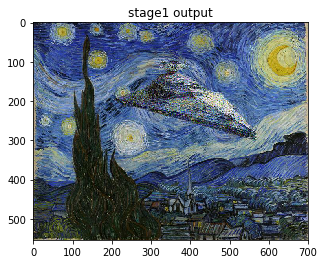

In [40]:
plt.title('stage1 output')
plt.imshow(Image.open(os.path.join(f'data/{index}_stage1_out.jpg')))

It looks fine for first glance but we can easily notice the object is suffering from somewhat colorful noise, which looks not wrong. I suspect that there are some faults in my implementation and will fix this someday. However, I have no idea left for right now, so lets go on to the stage2. Any suggestion on this(or other) part from anyone will be welcomed.

# Stage2

Prepare input images for second stage. 

In [28]:
image_index = 9
batch_inputs, img_tight_mask, img_dil_mask = prepare_input(data_dir='data/', index=image_index, stage=2)
batch_inputs = batch_inputs.to(device)

In [29]:
# model same as stage1
features = model(batch_inputs)[:-1]
ref_style = []
ref_content = []
uniq_masks = []
masks = resize_masks(img_dil_mask, features)
tmasks = resize_masks(img_tight_mask, features)

## Stage2: Mapping

mapping process for stage2 consists of three steps. First, we compute the neareast mapping indices using same function as independent mapping of stage1. Then, instead of applying this map only on layer used for computing that, we will broadcast this mapping to all the reference layers(upsample). Finally, we will compute the histogram of style activations which will be used as reference for histogram loss.

In [30]:
def apply_offset(idx, offset, size):
    dx, dy = offset
    w, h = size
    result = idx + dx
    # check index is not out of horizontal range 
    if result // w != idx // w:
        result = -1
    else:
        result += w * dy
    # check index is not out of vertical range 
    if result < 0 or result >= w * h:
        result = -1
    return result

def second_match(init_map, f_style, mask, kernel_size=5):
    c, w, h = f_style.shape
    # grid pointing to neighbors
    rad = (kernel_size - 1) // 2
    grid = [np.array([i,j]) for i in range(-rad,rad+1) for j in range(-rad,rad+1)]
    
    f_style = select_mask(f_style).t() # shape: (w*h, c)
    mask = mask.view(w*h, 1)
    result = init_map
    k = -1
    for i in range(f_style.shape[0]):
        if mask[i] == 0:
            continue
        else:
            k += 1
        candidates = set()
        ngb_s = []
        for offset in grid:
            i = apply_offset(i, offset, (w, h))
            if i != -1:
                j = apply_offset(init_map[k].item(), -offset, (w, h))

                if j != -1:
                    candidates.add(j)
                    ngb_s.append(j)
        candidates = torch.tensor(list(candidates), device=device, dtype=torch.int64)
        ngb_s = torch.tensor(ngb_s, device=device, dtype=torch.int64)
        
        if len(candidates) <= 1:
            assert(not candidates.empty())
            assert(candidates[0] == i)
        
        cand_ft = torch.index_select(f_style, 0, candidates)
        ngbr_ft = torch.index_select(f_style, 0, ngb_s)
        l2_dist = ((cand_ft[:, None, :] - ngbr_ft[None,:, :]) ** 2)
        l2_dist = l2_dist.sum(dim=2).sum(dim=1)
        result[k] = candidates[torch.argmin(l2_dist)]

    return result

Following function broadcasts the computed nearest neighbor mapping to the other layers. While doing that, we build a mask that covers duplicate elements in style activation.

In [31]:
def upsample(ref_map, ref_size, new_size, mask_ref, mask_new):
    r_h, r_w = ref_size
    n_h, n_w = new_size
    new_map = torch.zeros(mask_new.sum().item(), device=device, dtype=torch.int64)
    ratio_h, ratio_w = n_h/r_h, n_w/r_w
    k, l = -1, -1

    ref_idx_map = torch.full(mask_ref.shape, -1, device=device, dtype=torch.int64).masked_scatter_(mask_ref, ref_map)
    uniq_mask = torch.zeros_like(mask_new, dtype=torch.uint8) # mask that covers unique elts(activations) only
    uniq_elts = set()
    for i in range(n_h * n_w):
        n_x, n_y = i//n_w, i%n_w
        r_x, r_y = int((0.5+n_x) / ratio_h), int((0.5+n_y)/ratio_w)
        r_x, r_y = min(max(0,r_x),r_h-1), min(max(0,r_y),r_w-1)

        if mask_new[n_x, n_y] == 0 or mask_ref[r_x, r_y] == 0:
            continue
        else: 
            k += 1
            
        style_idx = ref_idx_map[r_x, r_y].item()
        s_x = int(n_x + (style_idx // r_w - r_x) * ratio_h + 0.5)
        s_y = int(n_y + (style_idx % r_w - r_y) * ratio_w + 0.5)
        s_x, s_y = min(max(0,s_x),n_h-1), min(max(0,s_y),n_w-1)
        new_map[k] = s_x * n_w + s_y

        if style_idx not in uniq_elts:
            uniq_elts.add(style_idx)
            uniq_mask[n_x, n_y] = 1
    return new_map, uniq_mask

def hist_mask(ft_style, uniq_mask, n_bins=256):
    ft_style = ft_style.cpu()
    uniq_mask = uniq_mask.cpu()
    masked = torch.masked_select(ft_style, uniq_mask).view(ft_style.shape[0], -1)
    return torch.cat([torch.histc(l, n_bins).unsqueeze(0) for l in masked]) 

In [34]:
print('Stage2: Begin Mapping')
with torch.no_grad():
    for i, (feat, mask) in enumerate(zip(features, masks)):
        feat_no_grad = feat
        f_style, f_content, f_stage1 = torch.unbind(feat.detach(), dim=0)
        if i == 3:
            init_map = nearest_search(f_stage1, f_style, mask)
            sec_map = second_match(init_map, f_style, mask, kernel_size=5) # TODO: try with resized original style image 
            mask_ref = mask
            size_ref = f_style.shape[-2:]

        ref_style.append(f_style)
        ref_content.append(f_stage1) 

    for i, (f_style, mask) in enumerate(zip(ref_style, masks)):
        new_map, uniq_mask = upsample(sec_map, size_ref, f_style.shape[-2:], mask_ref, mask)
        uniq_masks.append(uniq_mask)

    ref_hist = []
    for i, (f_style, uniq_mask) in enumerate(zip(ref_style, uniq_masks)):
        if i in [0, 3]:
            hist = hist_mask(f_style, uniq_mask)
            ref_hist.append(hist)

Stage2: Begin Mapping


## Reconstruction

Compared to stage1, computing loss for stage2 is more complicated due to the two more terms, which are histogram loss and total variation loss. The histogram loss is known to stabilize the original loss function by [Wilmot et al.](https://arxiv.org/abs/1701.08893), while the total variation loss is known to imrove style transfer output images to be snoother by [Johnson et al.](https://arxiv.org/abs/1603.08155). 

In [41]:
# style loss
def loss_style_stage2(fts_target, fts_style, masks, tmasks, weight=0.01):
    s_loss = 0
    for target, ref_s, mask, tmask in zip(fts_target, fts_style, masks, tmasks):
        target = select_mask(target.squeeze(0), mask)
        ref_s = select_mask(ref_s, tmask)

        ref_s *= float(np.sqrt(mask.sum() / tmask.sum())) # regularize differences of n_elts of masks
        s_loss += gram_mse(target, ref_s)
    return s_loss * weight / 4


# hist loss
def remap_hist(x, hist_ref, n_bins=256):
    ch, n = x.size()
    sorted_x, sort_idx = x.data.sort(1)
    ymin, ymax = sorted_x[:, 0].unsqueeze(1), sorted_x[:, -1].unsqueeze(1)

    hist = hist_ref / hist_ref.sum(1).unsqueeze(1)# Normalization between the different lengths of masks.
    hist = hist.to(device)
    
    cum_ref = n * hist.cumsum(1).to(device)
    cum_prev = torch.cat([torch.zeros(ch, 1, device=device), cum_ref[:,:-1]],1)
    step = (ymax-ymin)/n_bins

    rng = torch.arange(1,n+1).unsqueeze(0).to(device) # rng: range
    
    idx = torch.cat([(cum_ref < k).sum(1, keepdim=True) for k in range(1, n + 1)], dim=1).long().to(device)
    
    ratio = (rng - torch.take(cum_prev, idx).view(ch, -1)) / (1e-8 + torch.take(hist, idx)).view(ch, -1)
    ratio = ratio.squeeze().clamp(0,1)
    new_x = ymin + (ratio + idx.float()) * step
    new_x[:,-1] = ymax.squeeze(1)
    new_x = torch.take(new_x,idx).view(ch, -1)
    return new_x

def hist_loss(fts_target, fts_hist, masks, indices=[0, 3]):
    h_loss = 0
    for i, (target, mask, ref_hist) in enumerate(zip(fts_target, masks, fts_hist)):
        if i in indices:
            target = select_mask(target.squeeze(0), mask)
            h_loss += F.mse_loss(target, remap_hist(target, ref_hist)) 
    return h_loss / 2

# total variation loss
def loss_totvar(out):
    return ((out[:,:-1,:] - out[:,1:,:]) ** 2).sum() + ((out[:,:,:-1] - out[:,:,1:]) ** 2).sum()

def get_med_tv(arr):
    ch, h, w = arr.shape
    arr1 = torch.cat([torch.zeros((ch,w), device=device)[:,None,:], arr], dim=1)
    arr2 = torch.cat([torch.zeros((ch,h), device=device)[:,:,None], arr], dim=2)
    return torch.median((arr1[:,:-1,:] - arr1[:,1:,:]) ** 2 + (arr2[:,:,:-1] - arr2[:,:,1:]) ** 2)

# assembling every loss terms above. content loss is identical as stage1
def stage2_loss(opt_img, style_tfm, output, ref_style, ref_content, ref_hist, masks, uniq_masks):
    mtv = get_med_tv(style_tfm)
    w_tv = float(10 / (1 + np.exp(min(mtv * 10**4 -25, 30)))) # TODO: handling overflow here

    c_loss = loss_content(output[3].squeeze(0), ref_content[3], masks[3], )
    s_loss = loss_style_stage2(output, ref_style, masks, uniq_masks)
    h_loss = hist_loss(output, ref_hist, masks, indices=[0, 3])
    t_loss = loss_totvar(opt_img[0])
    # print(c_loss.item(), s_loss.item(), h_loss.item(), (w_tv * t_loss).item())
    return c_loss + s_loss + h_loss + w_tv * t_loss

In [38]:
print('Stage2: Begin Reconstruction')
# prepare image to be optimized by copying stage1 output image
content = batch_inputs[2].unsqueeze(0)
opt_img = torch.tensor(content.data, requires_grad=True)

optimizer = optim.LBFGS([opt_img], lr=0.1)
n_iter = 0
max_iter = 200
show_iter = 20
while  n_iter <= max_iter: 
    def closure():
        optimizer.zero_grad()
        global n_iter
        n_iter += 1
        output = model(opt_img)

        loss = stage2_loss(opt_img, batch_inputs[1], output, ref_style, ref_content, ref_hist, masks, uniq_masks)
        loss.backward()
        if n_iter % show_iter == 0: 
            print(f'Iteration: {n_iter}, loss: {loss.item()}')
        return loss
    optimizer.step(closure)

Stage2: Begin Reconstruction
Iteration: 20, loss: 0.7866056561470032
Iteration: 40, loss: 0.1470678299665451
Iteration: 60, loss: 0.07737544178962708
Iteration: 80, loss: 0.05736926198005676
Iteration: 100, loss: 0.04983947053551674
Iteration: 120, loss: 0.04580063000321388
Iteration: 140, loss: 0.043218422681093216
Iteration: 160, loss: 0.04134614020586014
Iteration: 180, loss: 0.039951641112565994
Iteration: 200, loss: 0.03889206796884537
Iteration: 220, loss: 0.03802398219704628


## Stage2 output

In [36]:
output_path = f'data/{image_index}_stage2_out'

with torch.no_grad():
    tight_mask = tmasks[0].float()
    output_img = opt_img * tight_mask + batch_inputs[0] * (1 - tight_mask)

    np.save(f'{output_path}.npy', output_img.data.cpu().numpy())
    # print(opt_img.shape)

    #denormalize and save output image
    inv_tsfm = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.255]), 
        lambda x: x.clamp(0, 1),
        transforms.ToPILImage()])
    inv_tsfm(output_img.cpu().data[0]).save(f'{output_path}.jpg')

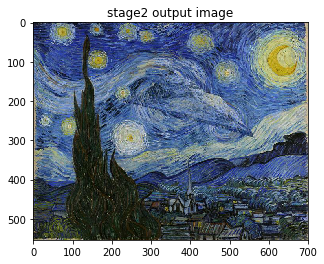

In [37]:
plt.title('stage2 output image')
plt.imshow(Image.open(os.path.join(f'data/{index}_stage2_out.jpg')))

## Conclusion

Although the final image of stage2 does not look bad, it lost much of fine details in original image, being compared to the result in original article. The highest chances are the presence of some mistakes in my implementation. The original article includes the post processing step with Chrominance Denoising, but I didn't tried implementing this step, because I felt that getting correct result in stage1 and stage2 should be preceded. 

### References
[Deep Painterly Harmonization Paper](https://arxiv.org/abs/1804.03189)

[Stable and Controllable Neural Texture Synthesis and Style Transfer Using Histogram Losses, Wilmot et al.](https://arxiv.org/abs/1701.08893)

[Perceptual Losses for Real-Time Style Transfer and Super-Resolution, Johnson et al.](https://arxiv.org/abs/1603.08155). 

[Authors' github repository](https://github.com/luanfujun/deep-painterly-harmonization)

[Sylvain Gugger's Blog](https://sgugger.github.io/deep-painterly-harmonization.html)